In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets,transforms
from torchvision.transforms import ToTensor, Lambda
import numpy as np
from tqdm.notebook import tqdm
from torchsummary import summary
import torchmetrics

# futures_data = h5['futures_data']  # VSTOXX futures data
# options_data = h5['options_data']  # VSTOXX call option data

# h5.close()

**Galaxy10 Dataset (21785 images) SDSS (not using anymore) (64x64)** 

- **Class 0 (3461 images):** Disk, Face-on, No Spiral
- **Class 1 (6997 images):** Smooth, Completely round
- **Class 2 (6292 images):** Smooth, in-between round
- **Class 3 (394 images):** Smooth, Cigar shaped
- **Class 4 (1534 images):** Disk, Edge-on, Rounded Bulge
- **Class 5 (17 images):** Disk, Edge-on, Boxy Bulge
- **Class 6 (589 images):** Disk, Edge-on, No Bulge
- **Class 7 (1121 images):** Disk, Face-on, Tight Spiral
- **Class 8 (906 images):** Disk, Face-on, Medium Spiral
- **Class 9 (519 images):** Disk, Face-on, Loose Spiral


**Galaxy10 Dataset (17736 images) DECALS (Use this) 128*128**

- **Class 0 (1081 images):** Disturbed Galaxies
- **Class 1 (1853 images):** Merging Galaxies
- **Class 2 (2645 images):** Round Smooth Galaxies
- **Class 3 (2027 images):** In-between Round Smooth Galaxies
- **Class 4 (334 images):** Cigar Shaped Smooth Galaxies
- **Class 5 (2043 images):** Barred Spiral Galaxies
- **Class 6 (1829 images):** Unbarred Tight Spiral Galaxies
- **Class 7 (2628 images):** Unbarred Loose Spiral Galaxies
- **Class 8 (1423 images):** Edge-on Galaxies without Bulge
- **Class 9 (1873 images):** Edge-on Galaxies with Bulge


In [2]:
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split
from sklearn.utils import resample

class CustomDataset(Dataset):
    def __init__(self, filename, transform=None):
        # self.data = torch.load(data_path)  # Load your custom data
        self.data = np.array(h5py.File(filename,'r')['images'])
        self.labels = np.array(h5py.File(filename,'r')['ans'])  # Load your labels
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        label = self.labels[idx]

        # sample = torch.tensor(sample, dtype=self.torch.float32)
        # label = torch.tensor(label, dtype=self.torch.float32)

        if self.transform:
            sample = self.transform(sample)
            
        label = torch.tensor(label, dtype=torch.long)
        return sample, label

def balance_dataset(dataset):
    # Calculate the class distribution
    label_counts = np.bincount(dataset.labels)

    # Find the class with the maximum count
    max_class_count = max(label_counts)

    # Oversample the minority classes to match the count of the majority class
    balanced_data = []
    for class_label in range(len(label_counts)):
        if label_counts[class_label] > 0:
            class_data = dataset.data[dataset.labels == class_label]
            oversampled_data = resample(class_data, n_samples=max_class_count, replace=True, random_state=42)
            balanced_data.append(oversampled_data)

    balanced_data = np.vstack(balanced_data)

    # Create a new dataset with balanced data
    balanced_dataset = CustomDataset("Galaxy10.h5",transform=transform)
    balanced_dataset.data = balanced_data
    balanced_dataset.labels = np.repeat(np.arange(len(label_counts)), max_class_count)

    return balanced_dataset


In [3]:

# transform = transforms.Compose([

#     transforms.ToTensor()])

transform = transforms.Compose([
    transforms.ToPILImage(),
    # transforms.RandomCrop(60, padding=1),
    # transforms.RandomGrayscale(p=0.1),
    transforms.Grayscale(),
    transforms.RandomRotation(20),
    transforms.CenterCrop(224),
    # transforms.Resize(size=69),
    transforms.ToTensor(),
    # transforms.RandomHorizontalFlip()
    ])
# custom_dataset = CustomDataset("Galaxy10_DECals.h5",transform=transform)
custom_dataset = CustomDataset("Galaxy10.h5",transform=transform)
balance_dataset = balance_dataset(custom_dataset)

# train_size = int(len(balance_dataset.data)*0.7)
# val_size = int(len(balance_dataset.data)-train_size)*0.2
# test_size = int(len(balance_dataset.data) - val_size)

train_set, val_set,test_set = torch.utils.data.random_split(balance_dataset, [0.7,0.2,0.1])



In [4]:
len(train_set),len(val_set),len(test_set)

(48979, 13994, 6997)

In [5]:
batch_size = 128
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size,shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size,shuffle=True)




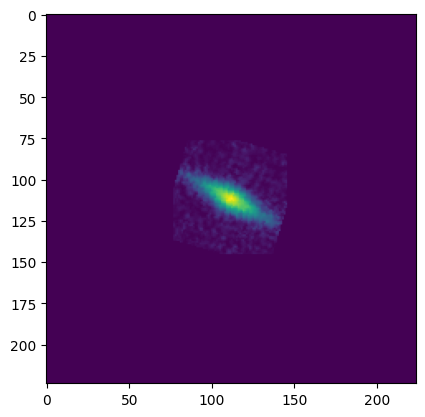

In [6]:
plt.imshow(test_loader.dataset[500][0].permute(1,2,0))

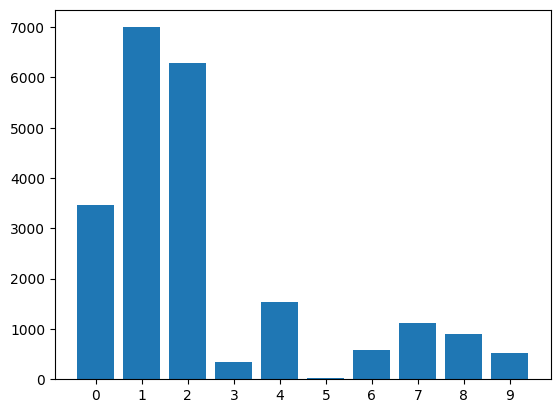

In [7]:
l, counts = np.unique(custom_dataset.labels, return_counts=True)
plt.bar(l, counts, align='center')
plt.gca().set_xticks(l);

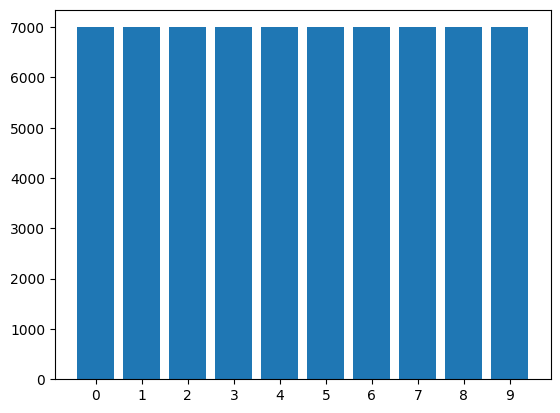

In [8]:
l, counts = np.unique(balance_dataset.labels, return_counts=True)
plt.bar(l, counts, align='center')
plt.gca().set_xticks(l);

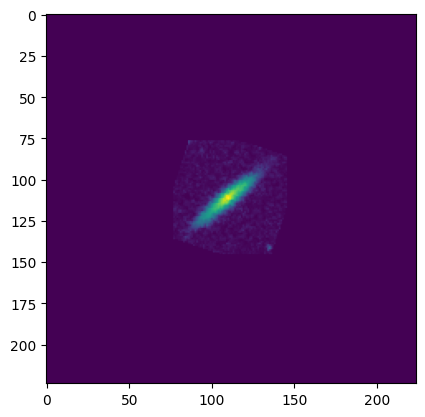

In [9]:
plt.imshow(train_loader.dataset[500][0][0])

In [10]:
import torch.nn.functional as F
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.batchnorm1 = nn.BatchNorm2d(64)  # Batch normalization
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.batchnorm2 = nn.BatchNorm2d(64)  # Batch normalization
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(18496, 128)
        self.relu3 = nn.ReLU()
        self.dropout = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool1(self.relu1(self.batchnorm1(self.conv1(x))))
        x = self.pool2(self.relu2(self.batchnorm2(self.conv2(x))))
        x = x.view(x.size(0), -1)
        x = self.dropout(self.relu3(self.fc1(x)))
        x = self.fc2(x)
        return x
        return x


In [11]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.block1 = nn.Sequential(
            # outputOfEachConvLayer = [(in_channel + 2*padding - kernel_size) / stride] + 1
                nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(5,3), padding=2, stride=1),
                nn.ReLU(),
                # nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(5,5), padding=2, stride=1),

                # nn.ReLU(),
                # nn.BatchNorm2d(32),
                
                # nn.ReLU(),
                # nn.MaxPool2d(kernel_size=5),
                
                # nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(5,3), padding=2, stride=1), ## adding this layer makes it over fit
                # nn.BatchNorm2d(64),
                # nn.ReLU(),
                nn.MaxPool2d(kernel_size=2)
                # Since we applied maxpooling with kernel_size=2 we have to divide by 2, so we get
                # 14 / 2 = 7
        )

        self.block2 = nn.Sequential(
                # We have the output_channel=24 of our second conv layer, and 7*7 is derived by the formular 
                # which is the output of each convolutional layer
                # nn.Linear(in_features=1024, out_features=64),
                # nn.Linear(in_features=5400, out_features=64),          

                # nn.ReLU(),
                # nn.Linear(in_features=3072, out_features=128),
                nn.Linear(in_features=404992, out_features=10),
                # nn.Dropout(p=0.4), # The output is 10 which should match the size of our class
        )

    def forward(self, x):
        x = self.block1(x)
        x = x.view(x.size(0), -1)
        x = self.block2(x)
        # x =F.softmax(x, dim=1)
        return x


In [12]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class VG16(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv01 = nn.Conv2d(1, 64, 3)
        self.conv02 = nn.Conv2d(64, 64, 3)
        self.pool1 = nn.MaxPool2d(2, 2)

        self.conv03 = nn.Conv2d(64, 128, 3)
        self.conv04 = nn.Conv2d(128, 128, 3)
        self.pool2 = nn.MaxPool2d(2, 2)

        self.conv05 = nn.Conv2d(128, 256, 3)
        self.conv06 = nn.Conv2d(256, 256, 3)
        self.conv07 = nn.Conv2d(256, 256, 3)
        self.pool3 = nn.MaxPool2d(2, 2)

        self.conv08 = nn.Conv2d(256, 512, 3)
        self.conv09 = nn.Conv2d(512, 512, 3)
        self.conv10 = nn.Conv2d(512, 512, 3)
        self.pool4 = nn.MaxPool2d(2, 2)

        self.conv11 = nn.Conv2d(512, 512, 3)
        self.conv12 = nn.Conv2d(512, 512, 3)
        self.conv13 = nn.Conv2d(512, 512, 3)
        self.pool5 = nn.MaxPool2d(2, 2)

        self.avepool1 = nn.AdaptiveAvgPool2d((7, 7))

        self.fc1 = nn.Linear(512 * 7 * 7, 4096)
        self.fc2 = nn.Linear(4096, 4096)
        self.fc3 = nn.Linear(4096, 10)

        self.dropout1 = nn.Dropout(0.5)
        self.dropout2 = nn.Dropout(0.5)



    def forward(self, x):
        x = F.relu(self.conv01(x))
        x = F.relu(self.conv02(x))
        x = self.pool1(x)

        x = F.relu(self.conv03(x))
        x = F.relu(self.conv04(x))
        x = self.pool2(x)

        x = F.relu(self.conv05(x))
        x = F.relu(self.conv06(x))
        x = F.relu(self.conv07(x))
        x = self.pool3(x)

        x = F.relu(self.conv08(x))
        x = F.relu(self.conv09(x))
        x = F.relu(self.conv10(x))
        x = self.pool4(x)

        x = F.relu(self.conv11(x))
        x = F.relu(self.conv12(x))
        x = F.relu(self.conv13(x))
        x = self.pool5(x)

        x = self.avepool1(x)

        # 行列をベクトルに変換
        x = x.view(-1, 512 * 7 * 7)
        
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)

        return x

In [13]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [14]:
model = VG16().to(device)
model

VG16(
  (conv01): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv02): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv03): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv04): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv05): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (conv06): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
  (conv07): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv08): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1))
  (conv09): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1))
  (conv10): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1))
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv11): Conv

In [15]:
summary(model, input_size=(1, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 222, 222]             640
            Conv2d-2         [-1, 64, 220, 220]          36,928
         MaxPool2d-3         [-1, 64, 110, 110]               0
            Conv2d-4        [-1, 128, 108, 108]          73,856
            Conv2d-5        [-1, 128, 106, 106]         147,584
         MaxPool2d-6          [-1, 128, 53, 53]               0
            Conv2d-7          [-1, 256, 51, 51]         295,168
            Conv2d-8          [-1, 256, 49, 49]         590,080
            Conv2d-9          [-1, 256, 47, 47]         590,080
        MaxPool2d-10          [-1, 256, 23, 23]               0
           Conv2d-11          [-1, 512, 21, 21]       1,180,160
           Conv2d-12          [-1, 512, 19, 19]       2,359,808
           Conv2d-13          [-1, 512, 17, 17]       2,359,808
        MaxPool2d-14            [-1, 51

In [16]:
lr = 1e-2
epochs = 10

loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
# optimizer = torch.optim.Adadelta(model.parameters(), lr=lr)



In [17]:
outputs_training, losses_training = [], []

outputs_test, losses_test = [] , []
metric_training = torchmetrics.classification.Accuracy(task="multiclass", num_classes=10)
metric_val = torchmetrics.classification.Accuracy(task="multiclass", num_classes=10)

metric_training.to(device)
metric_val.to(device)



accuracy_total_train, accuracy_total_val = [], []
for epoch in tqdm(range(epochs)):
    model.train()
    # total = 0

    total_correct = 0
    total_instances = 0

    running_loss = 0.0

    for (image, label) in train_loader:

      # Reshaping the image to (-1, 784)
      # image = image.reshape(-1, 28*28)
      image, label = image.to(device), label.to(device)
      optimizer.zero_grad()

      # Output of Autoencoder
      # print(image)
      pred = model(image)

      # Calculating the loss function
      loss = loss_function(pred, label)

      # The gradients are set to zero,
      # the gradient is computed and stored.
      # .step() performs parameter update

      # optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      classifications = torch.argmax(model(image), dim=1)
      correct_predictions = sum(classifications==label).item()
      # total_correct+=correct_predictions
      # total_instances+=len(image)
      acc = metric_training(pred, label)

      # running_loss =+ loss.item() * image.size(0)
      running_loss =+ loss.item() * image.size(0)


      # for i, p in enumerate(pred):
      #   if label[i] == torch.max(p.data, 0)[1]:
      #     total = total + 1
      # Storing the losses in a list for plotting
      # losses.append(loss.item())


    # losses_training.append(np.average(loss.item())*100)
    losses_training.append(running_loss / len(train_loader))

    outputs_training.append((epochs, image, pred))

    # accuracy_train = total / len(train_loader)
    # accuracy_total_train.append(round(total_correct/total_instances, 3)*100)
    accuracy_total_train.append(metric_training.compute())



    model.eval()
    total_correct = 0
    total_instances = 0
    running_loss = 0.0


    # with torch.no_grad():
    for (image, label) in val_loader:
        
        image, label = image.to(device), label.to(device)
        pred = model(image)
        loss = loss_function(pred, label)

        classifications = torch.argmax(model(image), dim=1)
        correct_predictions = sum(classifications==label).item()
        # total_correct+=correct_predictions
        # total_instances+=len(image)
        running_loss =+ loss.item() * image.size(0)
        acc = metric_val(pred, label)

        

    #     for i, p in enumerate(pred):
    #       if label[i] == torch.max(p.data, 0)[1]:
    #         total = total + 1
    #     # Storing the losses in a list for plotting
    #     # losses.append(loss.item())
    # losses_test.append(np.average(loss.item())*100)
    losses_test.append(running_loss / len(val_loader))

    
    # accuracy_val  = total / len(val_loader)
    # accuracy_total_val.append(round(total_correct/total_instances, 3)*100)
    accuracy_total_val.append(metric_val.compute())





    if epoch%5 == 0:
      # print(f'\n-------------------------------')
      print(f"Done Epoch {epoch}")
      print(f"Training Loss : {losses_training[-1]}")
      print(f"Validation Loss : {losses_test[-1]}")
      print()
      print(f"Training Accuracy : {accuracy_total_train[-1]}")
      print(f"Validation Accuracy : {accuracy_total_val[-1]}")

      print(f"-------------------------------\n")

  0%|          | 0/10 [00:00<?, ?it/s]

KeyboardInterrupt: 

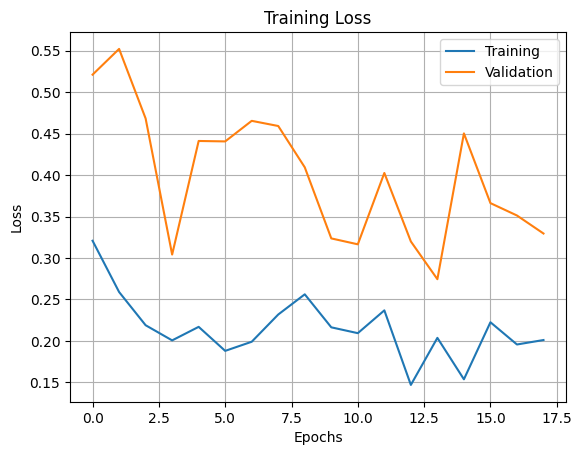

In [738]:
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
# Plotting the last 100 values
# losses = [i.detach().cpu().numpy() for i in losses[-1000:]]
plt.plot(losses_training,label='Training')
plt.plot(losses_test,label='Validation')
plt.legend()
plt.grid()

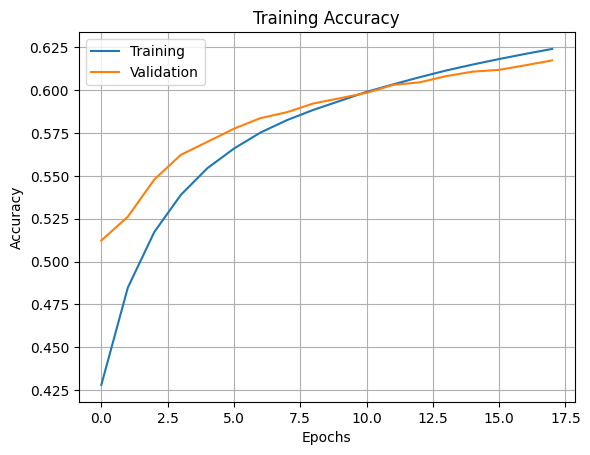

In [739]:
accuracy_total_train = [i.cpu().item() for i in accuracy_total_train ]
accuracy_total_val = [i.cpu().item() for i in accuracy_total_val ]

plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
# Plotting the last 100 values
# losses = [i.detach().cpu().numpy() for i in losses[-1000:]]
plt.plot(accuracy_total_train,label='Training')
plt.plot(accuracy_total_val,label='Validation')
plt.legend()
plt.grid()

In [44]:
accuracy_total_train[0].item()

0.3805916905403137

In [276]:

PATH =f'model/Galaxy_CNN_balanced_imporved_best2{epochs}epoch'
torch.save(model, PATH)

confusion matrix for genralizing 

import cv2

# model = torch.load('model/Galaxy_CNN_mdl130epoch_SDSS')
# model.eval()


# image_test = cv2.imread('eso0024a.jpg')
image_test = cv2.imread('NGC1376.jpg')

transform = transforms.Compose([transforms.ToTensor(),
                               transforms.Resize((69,69))])
image_test = transform(image_test)

# model(image)

In [576]:
idx_to_labels = ['Disk, Face-on, No Spiral',
                 'Smooth, Completely round',
                 'Smooth, in-between round',
                 'Smooth, Cigar shaped',
                 'Disk, Edge-on, Rounded Bulge',
                 'Disk, Edge-on, Boxy Bulge',
                 'Disk, Edge-on, No Bulge',
                 'Disk, Face-on, Tight Spiral',
                 'Disk, Face-on, Medium Spiral',
                 'Disk, Face-on, Loose Spiral']

from torchmetrics.classification import MulticlassConfusionMatrix
y_pred = []
y_true = []
confmat = MulticlassConfusionMatrix(num_classes=10)

for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        output = model(inputs) # Feed Network
        output = (torch.max(torch.exp(output), 1)[1])
        confmat.update(output.cpu(), labels.cpu())
        # output = (torch.max(output)).data.cpu().numpy()

        # y_pred.extend(output) # Save Prediction
        
        # labels = labels.data.cpu().numpy()
        # y_true.extend(labels) # Save Truth
confmat.plot()


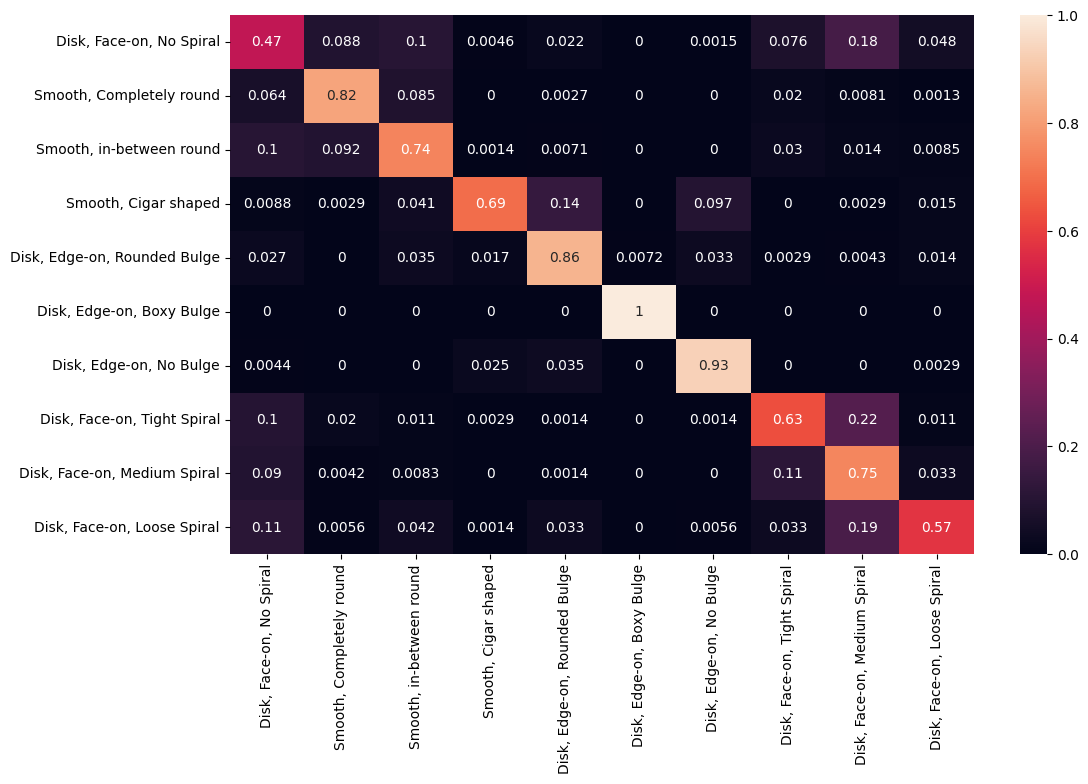

In [577]:
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix

y_pred = []
y_true = []
for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        output = model(inputs) # Feed Network
        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        # output = (torch.max(output)).data.cpu().numpy()

        y_pred.extend(output) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred,labels=[0,1,2,3,4,5,6,7,8,9])
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in idx_to_labels],
                     columns = [i for i in idx_to_labels])
plt.figure(figsize = (12,7))
heatmap = sns.heatmap(df_cm, annot=True)

In [ ]:
plt.imshow()

---

In [151]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device
PATH =f'model/Galaxy_CNN_balanced_imporved_best{epochs}epoch'

model = torch.load(PATH)
# model.(torch.load('model/Galaxy_CNN_mdl130epoch'))

Text(0.5, 1.0, '0')

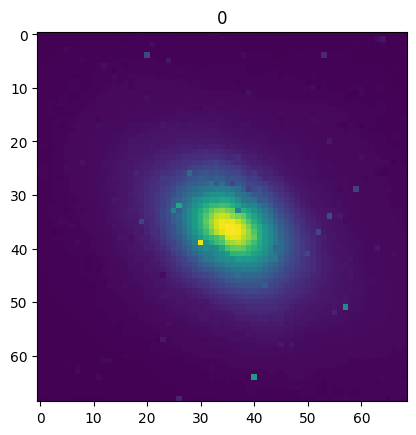

In [509]:
import cv2
image_test = cv2.imread('eso0024a.jpg')
# image_test = cv2.imread('7.png')

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Grayscale(),
    transforms.ToTensor(),transforms.Resize([69,69])])

index = 60
# image_test = transform(test_set.dataset.data[index])

image_test = transform(image_test)

plt.imshow(image_test.permute(1,2,0).contiguous())
# plt.imshow(image_test)

plt.title(test_set.dataset.labels[index])

In [511]:
image_test = image_test.float()
image_test = image_test.unsqueeze_(0)

# image_test = image_test.permute(0, 1,2).contiguous()
# plt.imshow(image_test.permute(1,2,3,0))

In [512]:
len(balance_dataset)

69970

In [513]:
image_test.size()

torch.Size([1, 1, 69, 69])

**Galaxy10 Dataset (21785 images)**

- **Class 0 (3461 images):** Disk, Face-on, No Spiral
- **Class 1 (6997 images):** Smooth, Completely round
- **Class 2 (6292 images):** Smooth, in-between round
- **Class 3 (394 images):** Smooth, Cigar shaped
- **Class 4 (1534 images):** Disk, Edge-on, Rounded Bulge
- **Class 5 (17 images):** Disk, Edge-on, Boxy Bulge
- **Class 6 (589 images):** Disk, Edge-on, No Bulge
- **Class 7 (1121 images):** Disk, Face-on, Tight Spiral
- **Class 8 (906 images):** Disk, Face-on, Medium Spiral
- **Class 9 (519 images):** Disk, Face-on, Loose Spiral


In [514]:
import torch.nn.functional as F

idx_to_labels = ['Disk, Face-on, No Spiral',
                 'Smooth, Completely round',
                 'Smooth, in-between round',
                 'Smooth, Cigar shaped',
                 'Disk, Edge-on, Rounded Bulge',
                 'Disk, Edge-on, Boxy Bulge',
                 'Disk, Edge-on, No Bulge',
                 'Disk, Face-on, Tight Spiral',
                 'Disk, Face-on, Medium Spiral',
                 'Disk, Face-on, Loose Spiral']
model.eval()
image_test = image_test.to(device)
# pred = model(image_test)
pred = model(image_test)
pred = F.softmax(pred,dim=1)
prediction_score, pred_label_idx = torch.topk(pred, 1)
pred_label_idx.squeeze_()
predicted_label = idx_to_labels[pred_label_idx.item()]
print('Predicted:', predicted_label, '(', prediction_score.squeeze().item(), ')')


Predicted: Disk, Edge-on, Rounded Bulge ( 0.7958556413650513 )


In [515]:
from captum.attr import IntegratedGradients, Occlusion, LayerGradCam, LayerAttribution
ig = IntegratedGradients(model)
attributions = ig.attribute(image_test, target=pred_label_idx)

In [516]:
image_test.squeeze(0).size()

torch.Size([1, 69, 69])

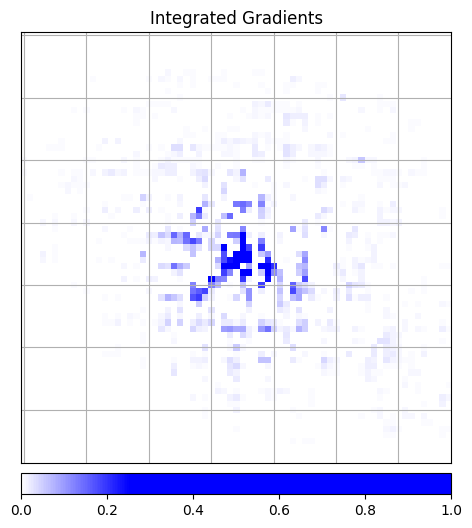

In [517]:
from captum.attr import visualization as viz
from matplotlib.colors import LinearSegmentedColormap

_ = viz.visualize_image_attr(None, np.transpose(image_test.squeeze(0).cpu().detach().numpy(), (1,2,0)),
                      method="original_image", title="Original Image",use_pyplot=False)

default_cmap = LinearSegmentedColormap.from_list('custom blue',
                                                 [(0, '#ffffff'),
                                                  (0.25, '#0000ff'),
                                                  (1, '#0000ff')], N=256)

_ = viz.visualize_image_attr(np.transpose(attributions.squeeze(0).cpu().detach().numpy(), (1,2,0)),
                             np.transpose(image_test.squeeze(0).cpu().detach().numpy(), (1,2,0)),
                             method='heat_map',
                             cmap=default_cmap,
                             show_colorbar=True,
                             sign='positive',
                             title='Integrated Gradients')

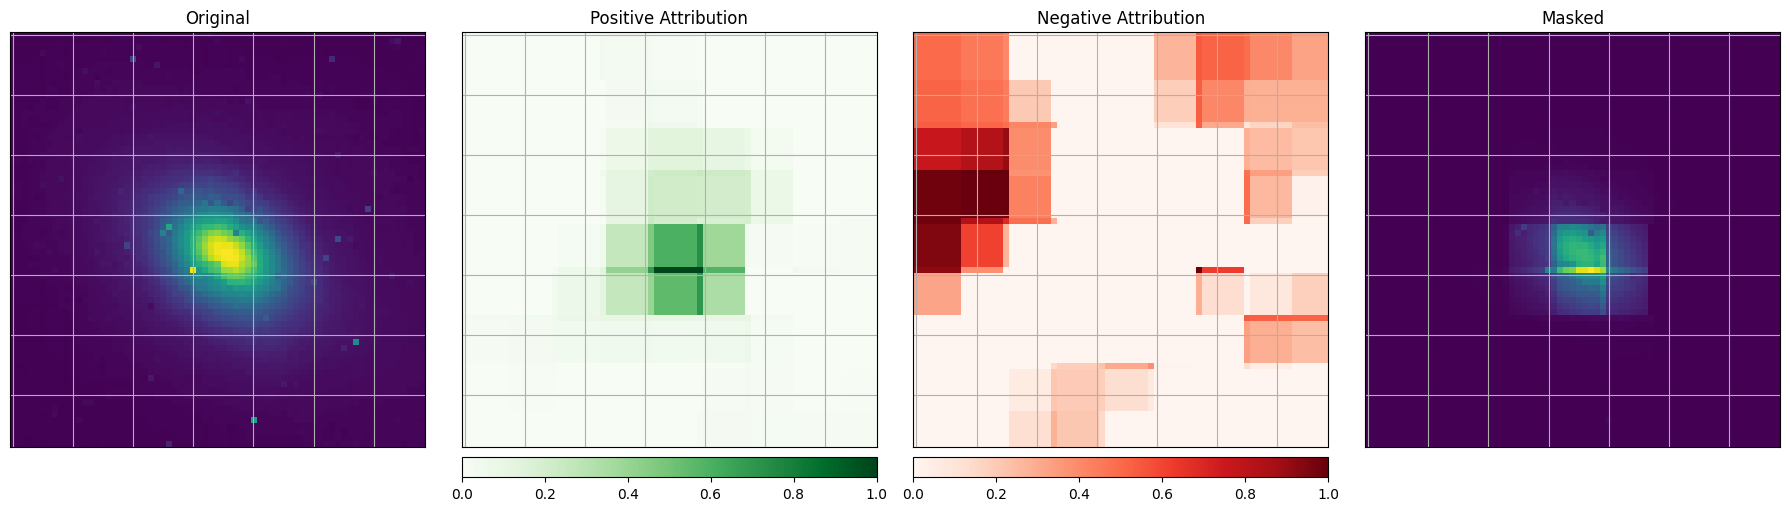

In [518]:
occlusion = Occlusion(model)

attributions_occ = occlusion.attribute(image_test,
                                       target=pred_label_idx,
                                       strides=(3, 8, 8),
                                       sliding_window_shapes=(1,15, 15),
                                       baselines=0)


_ = viz.visualize_image_attr_multiple(np.transpose(attributions_occ.squeeze(0).cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(image_test.squeeze(0).cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map", "heat_map", "masked_image"],
                                      ["all", "positive", "negative", "positive"],
                                      show_colorbar=True,
                                      titles=["Original", "Positive Attribution", "Negative Attribution", "Masked"],
                                      fig_size=(18, 6)
                                     )

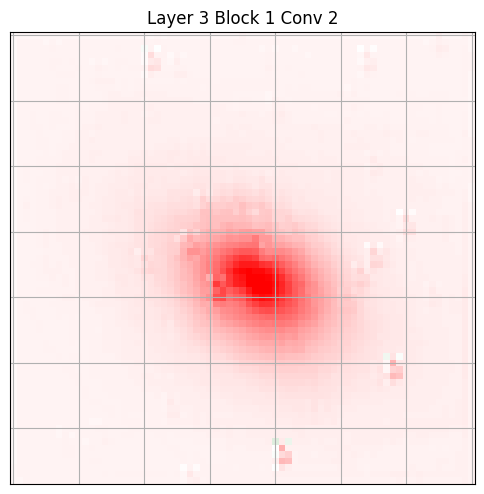

In [519]:
layer_gradcam = LayerGradCam(model, model.block1[0])
attributions_lgc = layer_gradcam.attribute(image_test, target=pred_label_idx)

_ = viz.visualize_image_attr(attributions_lgc[0].cpu().permute(1,2,0).detach().numpy(),
                             sign="all",
                             title="Layer 3 Block 1 Conv 2")


In [274]:
model.block1

Sequential(
  (0): Conv2d(3, 32, kernel_size=(9, 9), stride=(1, 1), padding=(2, 2))
  (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): MaxPool2d(kernel_size=5, stride=5, padding=0, dilation=1, ceil_mode=False)
  (4): Conv2d(32, 32, kernel_size=(9, 9), stride=(1, 1), padding=(2, 2))
  (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): ReLU()
  (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)

torch.Size([1, 1, 69, 71])
torch.Size([1, 1, 69, 69])
torch.Size([1, 1, 69, 69])


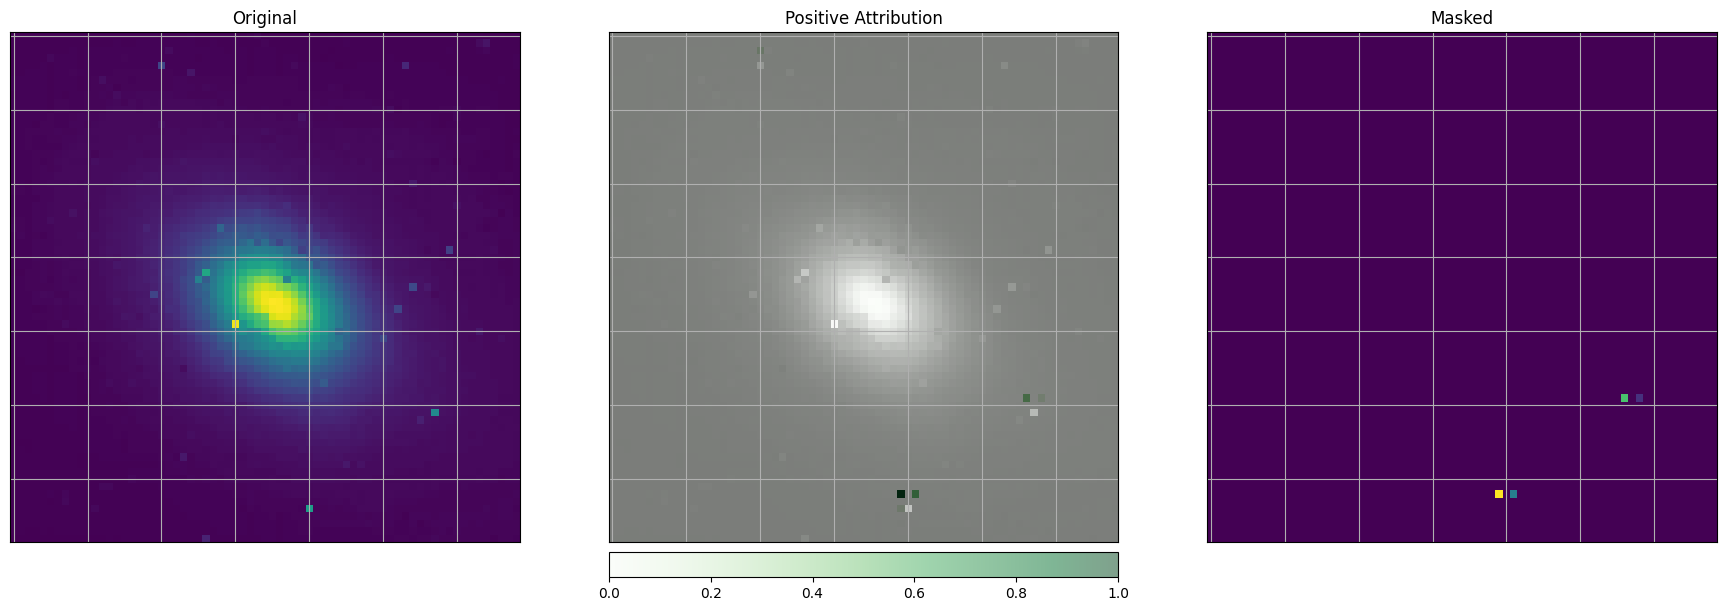

In [520]:
upsamp_attr_lgc = LayerAttribution.interpolate(attributions_lgc, image_test.shape[2:])

print(attributions_lgc.shape)
print(upsamp_attr_lgc.shape)
print(image_test.shape)

_ = viz.visualize_image_attr_multiple(upsamp_attr_lgc[0].cpu().permute(1,2,0).detach().numpy(),
                                      image_test.cpu().squeeze(0).permute(1,2,0).detach().numpy(),
                                      ["original_image","blended_heat_map","masked_image"],
                                      ["all","positive","positive"],
                                      show_colorbar=True,
                                      titles=["Original", "Positive Attribution", "Masked"],
                                      fig_size=(18, 6))